<a href="https://colab.research.google.com/github/me1nna/fake-image-detection/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet for fake images detection

###Установка зависимостей

In [ ]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import random
import os

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision.transforms import v2
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = "42"

In [ ]:
import PIL
print(PIL.__version__)

9.4.0


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Apr  4 09:10:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

##Анализ и загрузка данных

In [ ]:
!gdown --id 13rZ1HNOWsN-cTYgYHu0S3UYUHI0KAUBV
!gdown --id 1qjK-uwy20OAWCO1l39RNvjRgjsZiFqm0
!gdown --id 1Heeu9E9vI3MtkYE-_iZdGGcytm5Mw8ha
!gdown --id 1vnG3dlMb9wxo0P-noc84LUBaZNjwumMq
!gdown --id 1BW2ARIM2r0EgL5Z4A8E0O4PXB2BNRhmA

!unzip "images.zip"

In [ ]:
import seaborn as sns
import pandas as pd

In [ ]:
data = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

In [ ]:
data.shape[0], data_test.shape[0]

(1012, 506)

In [ ]:
data

,id,target
0,gL5fWrgNPU.jpg,0
1,KKWXJDN8uM.png,1
2,Wb2I0CXlAY.jpg,0
3,G7PLhKpaf7.jpeg,1
4,DEUkeefz6Z.jpg,0
...,...,...
1007,fqoVycdxLV,1
1008,TN2ZOiNI5e.jpg,0
1009,2WMWt6CAWQ.jpg,0
1010,fQCY5n2vcF.jpg,0


###Посмотрим на распределение классов

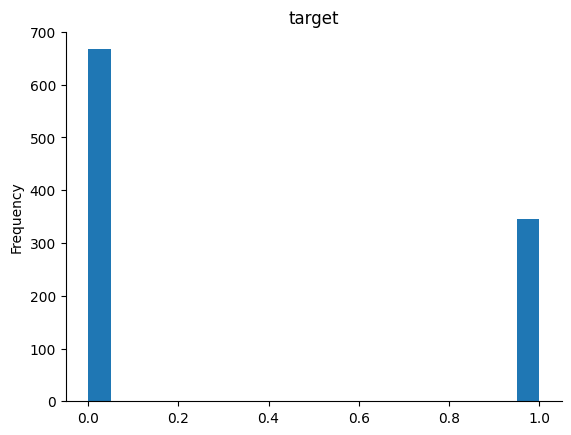

In [ ]:
data['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)

Классы, очевидно, не сбалансированы

## Функция для создания списка из названий файлов (понадобится дальше для загрузки датасета)
Можно заметить, что некоторые файлы в датафрейме не имеют расширения. С помощью простого просмотра файлов становится ясно: если расширение пропущено, то у файла .png

In [ ]:
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        full_path = os.path.join('/content/images', image_path)
        if not os.path.isfile(full_path):
            full_path += ".png"
        try:
            images.append(full_path)
        except Exception as e:
            print(f"Не удалось загрузить изображение: {full_path}")
            print(f"Ошибка: {e}")
            continue
    return images

In [ ]:
# загрузим файлы

train_files = load_images(data["id"])
test_files = load_images(data_test["id"])

Функция для загрузки изображения из тензора (для отображения)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'test'] # тренируем на всем  трейне, без валидационной выборки
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [ ]:
class FakeDatasetAdvanced(Dataset):
    """
    Класс датасета с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, labels=None):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        if self.mode != 'test':
            self.labels = labels

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        # некоторые картинки png, соответственно имеют формат RGBA. Будем переводить всех в ргб для упрощения работы с ними =)
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def __getitem__(self, index):
        if self.mode == 'test':
            transform = v2.Compose([
                v2.Resize(size=(224,224), antialias=True),
                v2.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        else:
            augmentations = v2.RandomChoice([
                v2.RandomRotation(degrees=(-25, 25)),
                v2.RandomHorizontalFlip(p=1),
                v2.RandomPerspective(distortion_scale=0.3, p=1.0),
                v2.RandomPosterize(bits=4)
            ])
            transform = v2.Compose([
                augmentations,
                v2.Resize(size=(224,224), antialias=True),
                v2.Lambda(lambda x: np.array(x, dtype='float32') / 255),
                transforms.ToTensor(),
                v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            return x, label

In [ ]:
# загрузим картинки

train_dataset = FakeDatasetAdvanced(train_files, mode='train', labels=data["target"])
test_dataset = FakeDatasetAdvanced(test_files, mode="test")

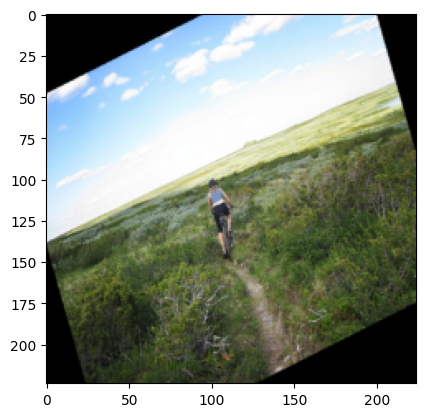

In [ ]:
# посмотрим на рандомное изображение из трейна

imshow(train_dataset[5][0])

Произведем выравнивание изображений для классов

In [ ]:
from torch.utils.data import WeightedRandomSampler

In [ ]:
df = pd.DataFrame(data["target"], columns=['class']).value_counts().to_frame().reset_index()
counts = pd.Series(data["target"]).value_counts()

In [ ]:
counts

target
0    667
1    345
Name: count, dtype: int64

In [ ]:
# Словарь весов для каждого из классов
weights = counts.astype(float).apply(lambda x: 1/x).to_dict()

# Список весов для каждого элемента из датасета
sample_weights = [weights[label] for label in train_dataset.labels]

# Общее число элементов в датасете, с учетом весов
N = counts.max().tolist() * len(weights)


In [ ]:
weights, N

({0: 0.0014992503748125937, 1: 0.002898550724637681}, 1334)

In [ ]:
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N, replacement=True)

Напишем простейшую сверточную сетку, которая возвращает два аутпута

AdvancedCNN будет иметь 5 сверточных слоев, Leaky_Relu в качестве активации, далее три полносвязных слоя

In [ ]:
class AdvancedCNN(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # Полносвязные слои
        self.fl = nn.Flatten()
        self.ln1 = nn.Sequential(
            nn.Linear(in_features=96*5*5, out_features=1024, bias=True),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU()
        )
        self.ln2 = nn.Sequential(
            nn.Linear(in_features=1024, out_features=512, bias=True),
            nn.BatchNorm1d(512),
            nn.LeakyReLU()
        )
        self.out = nn.Linear(512, n_classes, bias=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.fl(x)
        x = self.ln1(x)
        x = self.ln2(x)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, batch_size, val_dataset, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    # Создание подвыборки (Subset) для валидации из 1280 элементов
    idxs = np.random.randint(0, len(val_dataset), size=512)
    dataset = Subset(val_dataset, idxs)

    #DataLoader для валидации, без аугментации данных
    val_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

    for inputs, labels in val_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

В качестве оптимизатора выбираем Adam

In [ ]:
def train(model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    train_acc {t_acc:0.4f} "

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        optimizer = optim.Adam(model.parameters(), lr=0.0005)

        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, exp_lr_scheduler)
            print("loss", train_loss)

            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           t_acc=train_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = 2
advanced_cnn = AdvancedCNN(n_classes).to(DEVICE)
print("Количество классов :{}".format(n_classes))
print(advanced_cnn)

Количество классов :2
AdvancedCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), strid

In [ ]:
batch_size=128

#DataLoader для тренировки, с семплером
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
history_all = []

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
history = train(model=advanced_cnn, epochs=20, batch_size=batch_size, train_loader=train_dataloader)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
epoch:   5%|▌         | 1/20 [00:21<06:40, 21.06s/it]

loss 0.9956368773594789

Epoch 001 train_loss: 0.9956     train_acc 0.5840


epoch:  10%|█         | 2/20 [00:39<05:53, 19.62s/it]

loss 0.6653066063928104

Epoch 002 train_loss: 0.6653     train_acc 0.5817


epoch:  15%|█▌        | 3/20 [00:59<05:33, 19.63s/it]

loss 0.6052660657905568

Epoch 003 train_loss: 0.6053     train_acc 0.6612


epoch:  20%|██        | 4/20 [01:18<05:10, 19.43s/it]

loss 0.5114330550183778

Epoch 004 train_loss: 0.5114     train_acc 0.7579


epoch:  25%|██▌       | 5/20 [01:38<04:56, 19.74s/it]

loss 0.43563671801043774

Epoch 005 train_loss: 0.4356     train_acc 0.7901


epoch:  30%|███       | 6/20 [01:57<04:32, 19.44s/it]

loss 0.4597768170544054

Epoch 006 train_loss: 0.4598     train_acc 0.7796


epoch:  35%|███▌      | 7/20 [02:16<04:12, 19.42s/it]

loss 0.39761102503386214

Epoch 007 train_loss: 0.3976     train_acc 0.8223


epoch:  40%|████      | 8/20 [02:35<03:49, 19.15s/it]

loss 0.4338672941681863

Epoch 008 train_loss: 0.4339     train_acc 0.8133


epoch:  45%|████▌     | 9/20 [02:55<03:33, 19.39s/it]

loss 0.37490950692361263

Epoch 009 train_loss: 0.3749     train_acc 0.8426


epoch:  50%|█████     | 10/20 [03:14<03:11, 19.19s/it]

loss 0.36889156605350204

Epoch 010 train_loss: 0.3689     train_acc 0.8336


epoch:  55%|█████▌    | 11/20 [03:32<02:49, 18.83s/it]

loss 0.3553387942700193

Epoch 011 train_loss: 0.3553     train_acc 0.8411


epoch:  60%|██████    | 12/20 [03:51<02:32, 19.05s/it]

loss 0.3198671370431937

Epoch 012 train_loss: 0.3199     train_acc 0.8538


epoch:  65%|██████▌   | 13/20 [04:10<02:12, 18.86s/it]

loss 0.3067809997023135

Epoch 013 train_loss: 0.3068     train_acc 0.8666


epoch:  70%|███████   | 14/20 [04:30<01:55, 19.20s/it]

loss 0.30473106773360736

Epoch 014 train_loss: 0.3047     train_acc 0.8651


epoch:  75%|███████▌  | 15/20 [04:48<01:34, 18.91s/it]

loss 0.2751742989003569

Epoch 015 train_loss: 0.2752     train_acc 0.8853


epoch:  80%|████████  | 16/20 [05:08<01:16, 19.24s/it]

loss 0.23110630373279195

Epoch 016 train_loss: 0.2311     train_acc 0.9025


epoch:  85%|████████▌ | 17/20 [05:27<00:58, 19.34s/it]

loss 0.22198515667997556

Epoch 017 train_loss: 0.2220     train_acc 0.9025


epoch:  90%|█████████ | 18/20 [05:45<00:37, 18.89s/it]

loss 0.33369020364809965

Epoch 018 train_loss: 0.3337     train_acc 0.8553


epoch:  95%|█████████▌| 19/20 [06:05<00:19, 19.14s/it]

loss 0.3607104920197105

Epoch 019 train_loss: 0.3607     train_acc 0.8411


epoch: 100%|██████████| 20/20 [06:24<00:00, 19.23s/it]

loss 0.25126283963223445

Epoch 020 train_loss: 0.2513     train_acc 0.8966


Можно заметить, что получается достаточно хорошая accuracy и лосс на трейне.

In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=8)
probs = predict(advanced_cnn, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
my_submit = pd.read_csv("sample_submission.csv")

In [ ]:
my_submit = pd.DataFrame({"id": my_submit["id"], "target": probs[:,1]})

Сабмит при меньшем количестве эпох обучения

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,0.223815
1,j4Rhioq7R3.jpeg,0.865285
2,rD0hgFHJUZ.jpeg,0.204002
3,aY5z1EJsJ6.jpeg,0.861502
4,qZ3IoxD2TE.jpeg,0.181817


Сабмит при 20 эпохах обучения (скор на кагле около 0.44 logloss)

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,0.920289
1,j4Rhioq7R3.jpeg,0.951937
2,rD0hgFHJUZ.jpeg,0.148749
3,aY5z1EJsJ6.jpeg,0.995041
4,qZ3IoxD2TE.jpeg,0.959022


In [ ]:
my_submit.to_csv("sub_2.csv", index=False)

Загрузим ResNet152, она будет иметь следующую архитектуру (с уже измененным последним слоем для классификации фейковых изображений):

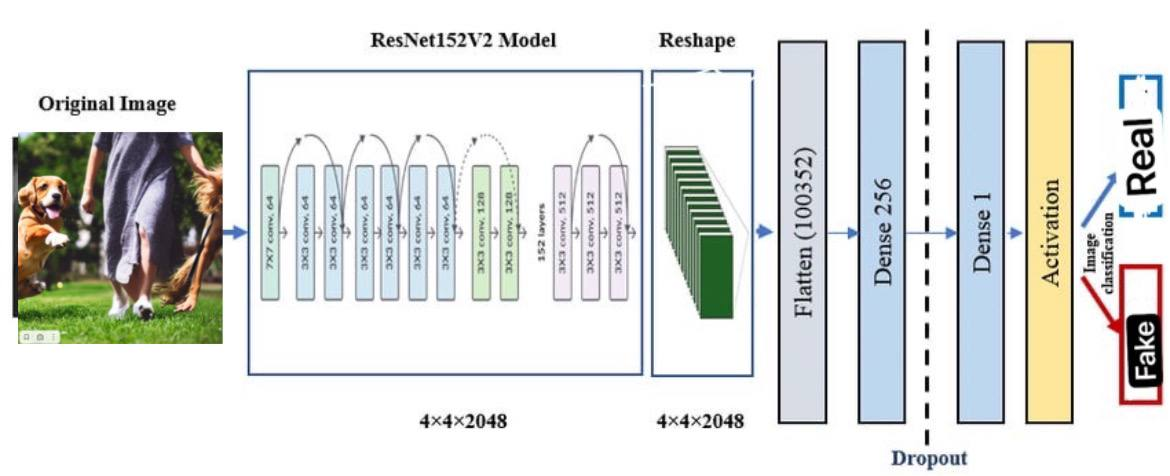

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
    scheduler.step()

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def train(model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    train_acc {t_acc:0.4f} "

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        optimizer = optim.Adam(model.parameters(), lr=0.0005)

        # Decay LR by a factor of 0.1 every 7 epochs
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, exp_lr_scheduler)
            print("loss", train_loss)

            history.append((train_loss, train_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                            t_acc=train_acc))

    return history

In [ ]:
import torchvision.models as models
import torch.optim as optim
from torchvision.models import ResNet152_Weights
from torch.optim import lr_scheduler
n_classes = 2

model = models.resnet152(weights=ResNet152_Weights.DEFAULT)

num_ftrs = model.fc.in_features

# изменяем последний слой
model.fc = nn.Linear(num_ftrs, n_classes)

model = model.to(DEVICE)

In [ ]:
history = train(model=model, epochs=23, batch_size=32)

epoch:   4%|▍         | 1/23 [00:39<14:35, 39.77s/it]

loss 0.03924859793041401

Epoch 001 train_loss: 0.0392     train_acc 0.9852 



epoch:   9%|▊         | 2/23 [01:18<13:38, 38.97s/it]

loss 0.058800514875782334

Epoch 002 train_loss: 0.0588     train_acc 0.9792 



epoch:  13%|█▎        | 3/23 [01:56<12:51, 38.59s/it]

loss 0.13283754661016667

Epoch 003 train_loss: 0.1328     train_acc 0.9634 



epoch:  17%|█▋        | 4/23 [02:34<12:13, 38.60s/it]

loss 0.06364547208010443

Epoch 004 train_loss: 0.0636     train_acc 0.9812 



epoch:  22%|██▏       | 5/23 [03:14<11:39, 38.85s/it]

loss 0.03581049794095602

Epoch 005 train_loss: 0.0358     train_acc 0.9872 



epoch:  26%|██▌       | 6/23 [03:53<11:01, 38.93s/it]

loss 0.06057366309871551

Epoch 006 train_loss: 0.0606     train_acc 0.9753 



epoch:  30%|███       | 7/23 [04:32<10:21, 38.87s/it]

loss 0.034950845256418346

Epoch 007 train_loss: 0.0350     train_acc 0.9891 



epoch:  35%|███▍      | 8/23 [05:10<09:40, 38.72s/it]

loss 0.02389652894008279

Epoch 008 train_loss: 0.0239     train_acc 0.9881 



epoch:  39%|███▉      | 9/23 [05:48<09:00, 38.60s/it]

loss 0.009485878854881412

Epoch 009 train_loss: 0.0095     train_acc 0.9980 



epoch:  43%|████▎     | 10/23 [06:27<08:21, 38.59s/it]

loss 0.00298157639975435

Epoch 010 train_loss: 0.0030     train_acc 1.0000 



epoch:  48%|████▊     | 11/23 [07:05<07:42, 38.55s/it]

loss 0.014699570334119826

Epoch 011 train_loss: 0.0147     train_acc 0.9951 



epoch:  52%|█████▏    | 12/23 [07:44<07:03, 38.54s/it]

loss 0.006969516973559682

Epoch 012 train_loss: 0.0070     train_acc 0.9980 



epoch:  57%|█████▋    | 13/23 [08:23<06:26, 38.65s/it]

loss 0.004408822063606954

Epoch 013 train_loss: 0.0044     train_acc 0.9980 



epoch:  61%|██████    | 14/23 [09:01<05:47, 38.63s/it]

loss 0.022490850422925247

Epoch 014 train_loss: 0.0225     train_acc 0.9951 



epoch:  65%|██████▌   | 15/23 [09:40<05:09, 38.71s/it]

loss 0.007205091383935803

Epoch 015 train_loss: 0.0072     train_acc 0.9980 



epoch:  70%|██████▉   | 16/23 [10:19<04:31, 38.81s/it]

loss 0.004501524973136608

Epoch 016 train_loss: 0.0045     train_acc 0.9980 



epoch:  74%|███████▍  | 17/23 [10:58<03:52, 38.83s/it]

loss 0.002120048330153252

Epoch 017 train_loss: 0.0021     train_acc 1.0000 



epoch:  78%|███████▊  | 18/23 [11:36<03:12, 38.58s/it]

loss 0.002008945455283696

Epoch 018 train_loss: 0.0020     train_acc 0.9990 



epoch:  83%|████████▎ | 19/23 [12:14<02:33, 38.48s/it]

loss 0.001173883749461059

Epoch 019 train_loss: 0.0012     train_acc 1.0000 



epoch:  87%|████████▋ | 20/23 [12:53<01:55, 38.40s/it]

loss 0.0009259209082841048

Epoch 020 train_loss: 0.0009     train_acc 1.0000 



epoch:  91%|█████████▏| 21/23 [13:36<01:19, 39.79s/it]

loss 0.0010658609700674954

Epoch 021 train_loss: 0.0011     train_acc 1.0000 



epoch:  96%|█████████▌| 22/23 [14:14<00:39, 39.47s/it]

loss 0.000141767534579651

Epoch 022 train_loss: 0.0001     train_acc 1.0000 



epoch: 100%|██████████| 23/23 [14:53<00:00, 38.83s/it]

loss 0.0006330354949658444

Epoch 023 train_loss: 0.0006     train_acc 1.0000 


In [ ]:
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=8)
probs = predict(model, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({"id": my_submit["id"], "target": probs[:,1]})

Сабмит при 5 эпохах

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,0.007509
1,j4Rhioq7R3.jpeg,0.257674
2,rD0hgFHJUZ.jpeg,0.014274
3,aY5z1EJsJ6.jpeg,0.999783
4,qZ3IoxD2TE.jpeg,0.000772


Сабмит при 15 эпохах

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,7.380288e-05
1,j4Rhioq7R3.jpeg,6.209967e-01
2,rD0hgFHJUZ.jpeg,1.954906e-05
3,aY5z1EJsJ6.jpeg,1.000000e+00
4,qZ3IoxD2TE.jpeg,3.349895e-07


Сабмит при 25 эпохах

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,7.799351e-05
1,j4Rhioq7R3.jpeg,1.547771e-02
2,rD0hgFHJUZ.jpeg,1.613684e-05
3,aY5z1EJsJ6.jpeg,1.000000e+00
4,qZ3IoxD2TE.jpeg,1.872056e-07


Сабмит при 25 эпохах ver 2

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,2.395829e-08
1,j4Rhioq7R3.jpeg,6.747239e-03
2,rD0hgFHJUZ.jpeg,8.173592e-06
3,aY5z1EJsJ6.jpeg,1.000000e+00
4,qZ3IoxD2TE.jpeg,2.163599e-06


Сабмит при 23 эпохах

In [ ]:
my_submit.head()

,id,target
0,Qt1fGUB0Vz.jpeg,0.000003
1,j4Rhioq7R3.jpeg,0.010430
2,rD0hgFHJUZ.jpeg,0.000007
3,aY5z1EJsJ6.jpeg,1.000000
4,qZ3IoxD2TE.jpeg,0.000001


Можно заметить следующее: с большим количеством эпох сеть становится увереннее в своих предсказаниях

In [ ]:
my_submit.to_csv("sub_mit5.csv", index=False)

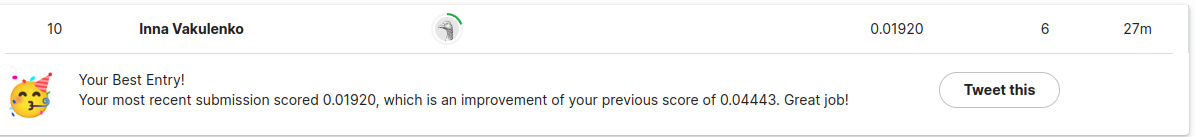